<a href="https://colab.research.google.com/github/cwmarris/pull-request-monitor/blob/master/05_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning to Improve Model Performance

- Author: Amy Zhuang
- Last Updated: May 2021

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout
from keras.activations import relu, sigmoid
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
import time

## Readin Data

In [ ]:
from sklearn import datasets
data = datasets.load_breast_cancer()

In [ ]:
data

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For

In [ ]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target']=data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [ ]:
df['target'].value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

## Standardization

In [ ]:
X_features = df[df.columns.difference(['target'])]

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X_features),index=X_features.index,columns=X_features.columns)
# Note: For the datasets with outliers, standardize using Robust Scaler

Add the describe after standardization

In [ ]:
X.describe()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-8.291551e-16,-3.921877e-16,-2.739461e-16,7.917900e-16,-3.366766e-16,-8.799835e-16,-1.120369e-15,9.732500e-16,-4.421380e-16,-1.453631e-15,-7.078891e-16,-3.162867e-15,6.132177e-15,-1.971670e-15,-6.530609e-15,1.773674e-15,-9.076415e-16,-7.541809e-16,-3.108234e-16,-8.853492e-16,5.049661e-16,-2.174788e-15,-1.412656e-16,6.856456e-16,2.575171e-15,-1.198026e-15,-2.333224e-15,-5.213170e-15,-2.289567e-15,1.763674e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-7.378291e-01,-1.298098e+00,-1.913447e+00,-1.057501e+00,-1.096968e+00,-1.454443e+00,-1.610136e+00,-1.261820e+00,-1.114873e+00,-1.819865e+00,-1.984504e+00,-2.029648e+00,-3.112085e+00,-2.744117e+00,-2.229249e+00,-1.044049e+00,-1.059924e+00,-1.776065e+00,-1.532890e+00,-1.554264e+00,-1.222423e+00,-1.443878e+00,-1.745063e+00,-1.305831e+00,-1.601839e+00,-1.693361e+00,-1.726901e+00,-2.682695e+00,-2.160960e+00,-2.223994e+00
25%,-4.947542e-01,-6.929263e-01,-6.744900e-01,-5.571612e-01,-5.851185e-01,-6.671955e-01,-7.470860e-01,-7.379438e-01,-7.437479e-01,-7.226392e-01,-6.919555e-01,-6.893853e-01,-7.109628e-01,-7.032397e-01,-7.259631e-01,-6.237679e-01,-6.235706e-01,-6.240183e-01,-6.516807e-01,-6.948092e-01,-6.421359e-01,-6.810833e-01,-7.563999e-01,-7.565142e-01,-6.919118e-01,-6.895783e-01,-6.749213e-01,-6.912304e-01,-6.418637e-01,-7.486293e-01
50%,-3.477828e-01,-2.810204e-01,-1.404958e-01,-1.990654e-01,-2.299405e-01,-2.951869e-01,-2.219405e-01,-3.977212e-01,-3.422399e-01,-1.782793e-01,-2.359800e-01,-2.150816e-01,-3.489108e-02,-7.162650e-02,-1.046362e-01,-2.866520e-01,-2.922452e-01,-2.203352e-01,-2.194304e-01,-1.974976e-01,-3.411812e-01,-2.695009e-01,-2.234689e-01,-2.182321e-01,-2.164441e-01,-2.859802e-01,-2.690395e-01,-4.684277e-02,-1.274095e-01,-4.351564e-02
75%,1.067726e-01,3.896541e-01,4.726567e-01,3.367521e-01,2.886421e-01,3.635073e-01,4.938569e-01,6.469351e-01,5.260619e-01,4.709834e-01,4.996769e-01,4.693926e-01,6.361990e-01,5.307792e-01,5.841756e-01,2.430307e-01,2.660996e-01,3.683553e-01,3.556925e-01,4.665523e-01,3.575891e-01,5.396688e-01,7.125100e-01,5.311411e-01,4.507624e-01,5.402790e-01,5.220158e-01,5.975448e-01,4.501382e-01,6.583411e-01
max,1.104184e+01,6.143482e+00,6.649601e+00,1.207268e+01,9.851593e+00,5.250529e+00,4.568425e+00,3.927930e+00,4.243589e+00,4.910919e+00,3.976130e+00,3.971288e+00,4.770911e+00,4.484751e+00,4.651889e+00,9.461986e+00,8.906909e+00,8.029999e+00,7.071917e+00,6.655279e+00,5.930172e+00,5.112877e+00,2.685877e+00,4.700669e+00,6.846856e+00,4.287337e+00,4.094189e+00,3.955374e+00,6.046041e+00,3.885905e+00


## Train Test Split

In [ ]:
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(455, 30)

In [ ]:
X_test.shape

(114, 30)

In [ ]:
y_train.shape

(455,)

In [ ]:
y_test.shape

(114,)

# XGBoost

## Check Default Parameters

In [ ]:
xgboost = XGBClassifier(seed=0)
from pprint import pprint
print('Parameters currently in use:\n')
pprint(xgboost.get_params())

# Reference: XGBoost documentation at https://xgboost.readthedocs.io/en/latest/parameter.html
# base_score: The initial prediction score of all instances, For sufficient number of iterations, changing this value will not have too much effect.
# booster: Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
# colsample_bylevel: is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.
# colsample_bynode: is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.
# colsample_bytree: is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
# gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
# learning_rate/eta: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
# max_delta_step: Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
# max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
# min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
# missing: Handles missing values
# n_estimators: Number of trees
# n_jobs: parallel processing when it equals -1
# nthread: Number of parallel threads used to run XGBoost. When choosing it, please keep thread contention and hyperthreading in mind.
# objective: When used with binary classification, the objective should be binary:logistic or similar functions that work on probability. When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, as the latter doesn’t output probability. 
# random_state: seed to get reproducible results
# reg_alpha: L1 regularization term on weights. Increasing this value will make model more conservative.
# reg_lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
# scale_pos_weight: Control the balance of positive and negative weights, useful for unbalanced classes.
# silent: control verbosity
# subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
# verbosity: Verbosity of printing messages. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug).

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


## Grid Search Cross Validation

In [ ]:
param_grid = { "learning_rate"    : [0.001, 0.01, 0.1] ,
 "max_depth"        : [ 3,  6, 12],
 "min_child_weight" : [ 1, 5, 9 ],
# Gamma specifies the minimum loss reduction required to make a split.
 "gamma"  : [0, 0.1, 0.3],
# Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
 "colsample_bytree" : [ 0.3, 0.5 , 0.8 ]}
param_grid

{'colsample_bytree': [0.3, 0.5, 0.8],
 'gamma': [0, 0.1, 0.3],
 'learning_rate': [0.001, 0.01, 0.1],
 'max_depth': [3, 6, 12],
 'min_child_weight': [1, 5, 9]}

In [ ]:
scoring = ['recall']

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
grid_search = GridSearchCV(xgboost, param_grid, scoring=scoring, refit='recall', n_jobs=-1, cv=kfold, verbose=1)
# scoring: Strategy to evaluate the performance of the cross-validated model on the test set.
# refit: Refit an estimator using the best found parameters on the whole dataset.

In [ ]:
grid_result = grid_search.fit(X_train, y_train)
# 3*3*3*3*3 = 243

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 726 out of 729 | elapsed:   29.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:   29.6s finished


In [ ]:
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:l...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'gamma': [0, 0.1, 0.3],
     

In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([0.06250374, 0.05191008, 0.04910382, 0.07277727, 0.05518071,
        0.05005407, 0.07430871, 0.05872679, 0.04865686, 0.05650997,
        0.05099328, 0.04730193, 0.07552703, 0.05546331, 0.04890482,
        0.07567143, 0.05576666, 0.05450511, 0.0528055 , 0.03794042,
        0.03260096, 0.05683374, 0.03883894, 0.03306731, 0.06021428,
        0.0389928 , 0.03641844, 0.05746524, 0.05213483, 0.04919871,
        0.07622385, 0.05454691, 0.04831592, 0.07153193, 0.05464705,
        0.04887056, 0.05703465, 0.05303176, 0.04939548, 0.07661319,
        0.05538487, 0.05433885, 0.07534099, 0.0676252 , 0.05128105,
        0.05029138, 0.03854394, 0.03447342, 0.0574379 , 0.0408566 ,
        0.03467989, 0.05886563, 0.03941107, 0.03901219, 0.05709084,
        0.05224919, 0.04828437, 0.07135987, 0.05643121, 0.04902029,
        0.0730443 , 0.05609171, 0.04994671, 0.05680569, 0.05747835,
        0.04845937, 0.07744988, 0.05831734, 0.05176957, 0.08050458,
        0.05900216, 0.05030306,

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_recall']
stds = grid_result.cv_results_['std_test_recall']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.986001 using {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1}
0.961477 (0.040649) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1}
0.947478 (0.045530) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 5}
0.958004 (0.031026) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 9}
0.964985 (0.035811) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 6, 'min_child_weight': 1}
0.947478 (0.045530) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 6, 'min_child_weight': 5}
0.958004 (0.031026) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 6, 'min_child_weight': 9}
0.964985 (0.035811) with: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 12, 'min_child_we

## Grid Search Final Model

In [ ]:
xgboost_gs = XGBClassifier(colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1).fit(X_train,y_train)

## Grid Search Prediction

In [ ]:
y_test_prob = xgboost_gs.predict_proba(X_test)[:,1]
y_test_predict = xgboost_gs.predict(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.989319,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.001732,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.003250,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.998543,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.999208,1


## Grid Search Performance

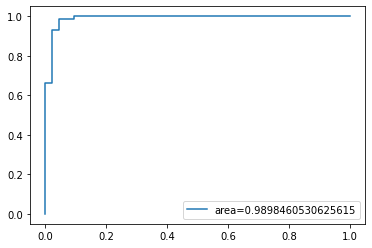

In [ ]:
#ROC/AUC Curve
from sklearn import metrics
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
log_loss(y_test,y_test_prob)

0.0991665813811491

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        40         3
true:yes        1        70


In [ ]:
print(classification_report(y_test, y_test_predict, digits=3))

              precision    recall  f1-score   support

           0      0.976     0.930     0.952        43
           1      0.959     0.986     0.972        71

    accuracy                          0.965       114
   macro avg      0.967     0.958     0.962       114
weighted avg      0.965     0.965     0.965       114



In [ ]:
Coeff = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(xgboost_gs.feature_importances_))], axis = 1)
Coeff.columns=['Variable','Feature_Importance']
CoeffSorted = Coeff.sort_values(by='Feature_Importance', ascending=False)
CoeffSorted

,Variable,Feature_Importance
25,worst perimeter,0.220260
22,worst concave points,0.121168
8,mean concavity,0.113353
26,worst radius,0.075156
20,worst area,0.056587
11,mean radius,0.050274
7,mean concave points,0.044541
21,worst compactness,0.041862
10,mean perimeter,0.038211
0,area error,0.024386


## Grid Search Feature Importance

Text(0, 0.5, 'Features')

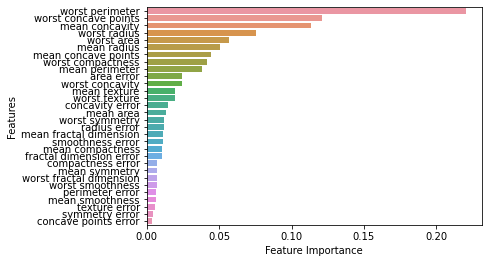

In [ ]:
ax = sns.barplot(x='Feature_Importance', y='Variable', data=CoeffSorted, order=CoeffSorted['Variable'])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')

## Grid Search Prediction Distribution

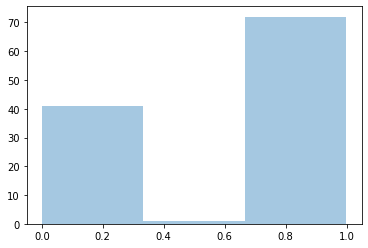

In [ ]:
# Plot the predicted probability distribution
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

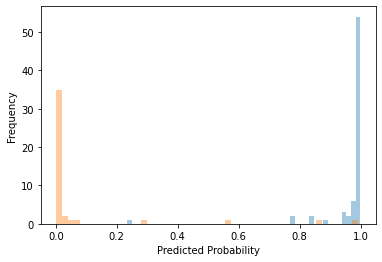

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Random Search Cross Validation

In [ ]:
# Randome Search param_grid
param_grid = {
# 
 "learning_rate": [0.0001, 0.001, 0.01, 0.1] ,
# The maximum depth of a tree, same as GBM.
 'max_depth':range(10,21,2),
# This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.    
 'min_child_weight':range(1,6,2),
#  node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.    
 'gamma':[i/10.0 for i in range(0,5)],
# Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.    
 'subsample':[i/10.0 for i in range(6,10)],
# Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
 'colsample_bytree':[i/10.0 for i in range(5,10)],
# Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.    
 'subsample':[i/100.0 for i in range(75,90,5)],
# L1 regularization
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
    }
param_grid

{'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': range(10, 21, 2),
 'min_child_weight': range(1, 6, 2),
 'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100],
 'subsample': [0.75, 0.8, 0.85]}

In [ ]:
scoring = ['recall']

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
random_search = RandomizedSearchCV(xgboost, param_grid, n_iter=100,scoring=scoring, refit='recall', n_jobs=-1, cv=kfold, verbose=1)

In [ ]:
random_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.6s finished


In [ ]:
random_result

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                      

In [ ]:
random_result.cv_results_

{'mean_fit_time': array([0.11260176, 0.0967892 , 0.1421601 , 0.12969788, 0.09197863,
        0.07753205, 0.09213456, 0.13853049, 0.09661547, 0.08170883,
        0.10742998, 0.04439219, 0.04850833, 0.04174582, 0.06618452,
        0.07702486, 0.12980882, 0.05725058, 0.10351046, 0.07297572,
        0.06971598, 0.06849019, 0.11175903, 0.089559  , 0.11001229,
        0.08421357, 0.09379601, 0.03872061, 0.10818068, 0.10149821,
        0.08457081, 0.05926243, 0.07481662, 0.10590076, 0.08937788,
        0.10073876, 0.10079336, 0.04209598, 0.09502935, 0.07721146,
        0.08209658, 0.0453136 , 0.05052423, 0.08035103, 0.07974299,
        0.08341551, 0.06859827, 0.10314298, 0.09953348, 0.09559329,
        0.0865473 , 0.11181943, 0.04878608, 0.09295861, 0.08129493,
        0.04467543, 0.05219165, 0.04474831, 0.1501383 , 0.07923849,
        0.12249041, 0.15209254, 0.05157908, 0.04147363, 0.10288334,
        0.12671701, 0.11095659, 0.08260123, 0.07472865, 0.03839238,
        0.08668303, 0.10750786,

In [ ]:
# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_recall']
stds = random_result.cv_results_['std_test_recall']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.978947 using {'subsample': 0.85, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.5}
0.943933 (0.042457) with: {'subsample': 0.8, 'reg_alpha': 1, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.0001, 'gamma': 0.0, 'colsample_bytree': 0.9}
0.947442 (0.044711) with: {'subsample': 0.8, 'reg_alpha': 1, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.0001, 'gamma': 0.3, 'colsample_bytree': 0.8}
0.957931 (0.037494) with: {'subsample': 0.85, 'reg_alpha': 1e-05, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.001, 'gamma': 0.0, 'colsample_bytree': 0.9}
0.964912 (0.042397) with: {'subsample': 0.85, 'reg_alpha': 0.01, 'min_child_weight': 1, 'max_depth': 16, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.6}
0.968421 (0.044659) with: {'subsample': 0.75, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 20, 'learning_rate': 0.0001, 'gamma': 0.4, 'colsample_bytree': 0.5}
0.9475

## Random Search Final Model

In [ ]:
xgboost_rs = XGBClassifier(seed=0, subsample=0.85, reg_alpha=10.1, min_child_weight=1, max_depth=18, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5).fit(X_train,y_train)

## Random Search Prediction

In [ ]:
y_test_prob = xgboost_rs.predict_proba(X_test)[:,1]
y_test_predict = xgboost_rs.predict(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.957385,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.058338,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.059088,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.963692,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.966031,1


## Random Search Model Performance

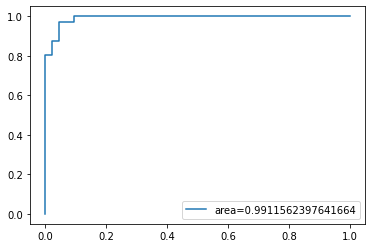

In [ ]:
#ROC/AUC Curve
from sklearn import metrics
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
log_loss(y_test,y_test_prob)

0.14446483523045717

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        40         3
true:yes        2        69


In [ ]:
print(classification_report(y_test, y_test_predict, digits=4))

              precision    recall  f1-score   support

           0     0.9524    0.9302    0.9412        43
           1     0.9583    0.9718    0.9650        71

    accuracy                         0.9561       114
   macro avg     0.9554    0.9510    0.9531       114
weighted avg     0.9561    0.9561    0.9560       114



## Random Search Feature Importance

In [ ]:
Coeff = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(xgboost_rs.feature_importances_))], axis = 1)
Coeff.columns=['Variable','Feature_Importance']
CoeffSorted = Coeff.sort_values(by='Feature_Importance', ascending=False)
CoeffSorted

,Variable,Feature_Importance
7,mean concave points,0.298057
25,worst perimeter,0.216578
22,worst concave points,0.089430
20,worst area,0.084101
21,worst compactness,0.052967
8,mean concavity,0.045955
5,mean area,0.034902
26,worst radius,0.026963
29,worst texture,0.021188
0,area error,0.017616


Text(0, 0.5, 'Features')

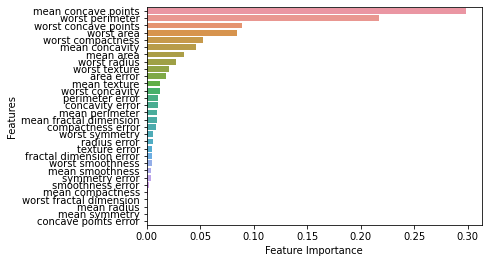

In [ ]:
ax = sns.barplot(x='Feature_Importance', y='Variable', data=CoeffSorted, order=CoeffSorted['Variable'])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')

## Random Search Prediction Distribution

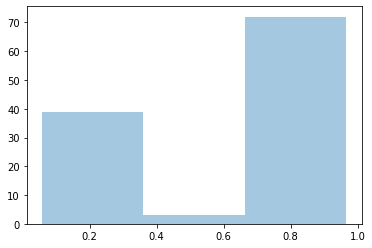

In [ ]:
# Plot the predicted probability distribution
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

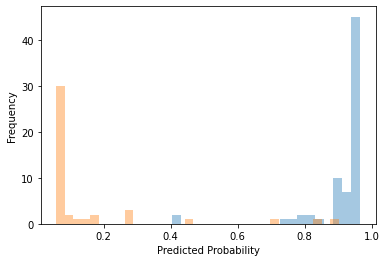

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Bayesian Optimization

In [ ]:
N_FOLDS = 3
MAX_EVALS = 100

In [ ]:
# Learning rate
learning_rate=[0.0001, 0.001, 0.01, 0.1] 
n_estimators=[100,300,500,1000]
# The maximum depth of a tree, same as GBM.
max_depth=range(10,21,2)
# This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.    
min_child_weight=range(1,6,2)
#  node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.    
gamma=[i/10.0 for i in range(0,5)]
# Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.    
subsample=[i/10.0 for i in range(6,10)]
# Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
colsample_bytree=[i/10.0 for i in range(5,10)]
# L1 regularization
reg_alpha=[1e-5, 1e-2, 0.1, 1, 10, 100]
    
param = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=max_depth,min_child_weight=min_child_weight,gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree,reg_alpha=reg_alpha)

In [ ]:
param

{'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': range(10, 21, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 300, 500, 1000],
 'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100],
 'subsample': [0.6, 0.7, 0.8, 0.9]}

In [ ]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', learning_rate),
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'max_depth' : hp.choice('max_depth', max_depth),
    'min_child_weight' : hp.choice('min_child_weight', min_child_weight),
    'gamma' : hp.choice('gamma', gamma),
    'subsample' : hp.choice('subsample', subsample),    
    'colsample_bytree' : hp.choice('colsample_bytree', colsample_bytree),     
    'reg_alpha' : hp.choice('reg_alpha', reg_alpha) 
}

In [ ]:
# Objective function
def objective(params, n_folds = N_FOLDS):

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC
    
    xgboost = XGBClassifier(seed=0, **params)
    scores = cross_val_score(xgboost, X_train, y_train, cv=n_folds, scoring='recall', n_jobs=-1)

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 100/100 [00:47<00:00,  2.10it/s, best loss: 0.0]


In [ ]:
# Best parameters:
best

{'colsample_bytree': 1,
 'gamma': 1,
 'learning_rate': 3,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 1,
 'reg_alpha': 3,
 'subsample': 2}

In [ ]:
{'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': range(10, 21, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 300, 500, 1000],
 'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100],
 'subsample': [0.6, 0.7, 0.8, 0.9]}

## Bayesian Optimization Final Model

In [ ]:
xgboost_bo = XGBClassifier(seed=0, colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=20, min_child_weight=3, subsample=0.8, reg_alpha=1, n_estimators=300).fit(X_train,y_train)

In [ ]:
xgboost_bo.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 20,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 300,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

## Bayesian Optimization Prediction

In [ ]:
y_test_prob = xgboost_bo.predict_proba(X_test)[:,1]
y_test_predict = xgboost_bo.predict(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.968536,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.001373,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.001544,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.997588,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.999184,1


## Bayesian Optimization Model Performance

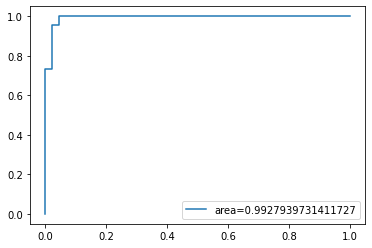

In [ ]:
#ROC/AUC Curve
from sklearn import metrics
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
log_loss(y_test,y_test_prob)

0.07979581276161123

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        41         2
true:yes        1        70


In [ ]:
print(classification_report(y_test, y_test_predict, digits=4))

              precision    recall  f1-score   support

           0     0.9762    0.9535    0.9647        43
           1     0.9722    0.9859    0.9790        71

    accuracy                         0.9737       114
   macro avg     0.9742    0.9697    0.9719       114
weighted avg     0.9737    0.9737    0.9736       114



## Bayesian Optimization Feature Importance

In [ ]:
Coeff = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(xgboost_bo.feature_importances_))], axis = 1)
Coeff.columns=['Variable','Feature_Importance']
CoeffSorted = Coeff.sort_values(by='Feature_Importance', ascending=False)
CoeffSorted

,Variable,Feature_Importance
7,mean concave points,0.307822
22,worst concave points,0.157712
25,worst perimeter,0.156790
20,worst area,0.081283
11,mean radius,0.039454
5,mean area,0.036256
8,mean concavity,0.028429
26,worst radius,0.025818
3,concavity error,0.022213
29,worst texture,0.020510


Text(0, 0.5, 'Features')

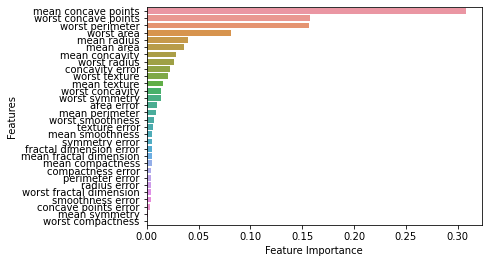

In [ ]:
ax = sns.barplot(x='Feature_Importance', y='Variable', data=CoeffSorted, order=CoeffSorted['Variable'])
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')

## Bayesian Optimization Prediction Distribution

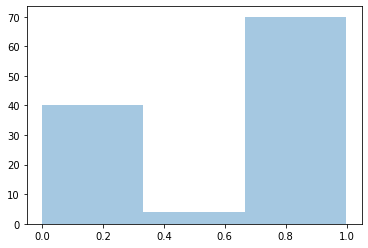

In [ ]:
# Plot the predicted probability distribution
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

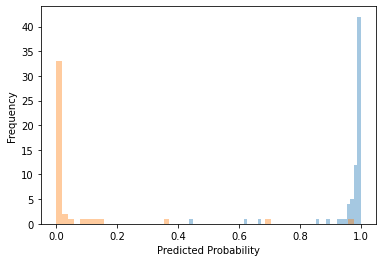

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Save Model

In [ ]:
import pickle
# save the model to disk
modelname = 'xgboost_bo_model.pkl'
pickle.dump(xgboost_bo, open(modelname, 'wb'))

In [ ]:
# load the model from disk
loaded_phase1_model = pickle.load(open(modelname, 'rb'))

# Neutal Network Model

## Grid Search Cross Validation

In [ ]:
layers = [(30), (30, 15)]# Need to use tuple instead of list because of a bug related to nested list with Keras. https://datascience.stackexchange.com/questions/66341/cannot-clone-object-keras-wrappers-scikit-learn-kerasregressor-object-at-0x7fdc
activations = ['tanh', 'relu']
batch_size = [32, 256]
epochs=[10, 50]
param_grid = dict(layers=layers, activation=activations, batch_size = batch_size, epochs=epochs)
param_grid

{'activation': ['tanh', 'relu'],
 'batch_size': [32, 256],
 'epochs': [10, 50],
 'layers': [30, (30, 15)]}

In [ ]:
scoring = ['recall']

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
l = enumerate(layers)
print(list(l))

[(0, 30), (1, (30, 15))]


In [ ]:
def create_model(layers, activation='relu', batch_size=32, epochs=50):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
            
    model.add(Dense(units = 1, activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
    return model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

# Change function to estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='recall', n_jobs=-1, cv=kfold, verbose=1)

grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   23.0s finished


In [ ]:
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa7c9d96400>,
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'batch_size': [32, 256], 'epochs': [10, 50],
                         'layers': [30, (30, 15)]},
             pre_dispatch='2*n_jobs', refit='recall', return_train_score=False,
             scoring=['recall'], verbose=1)

In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([0.00466077, 1.30289054, 0.00261458, 2.01705122, 0.00263262,
        1.13590185, 0.00270025, 1.31156119, 0.00294018, 1.40193327,
        0.00255156, 2.10102916, 0.00264525, 1.132821  , 0.00260703,
        1.12254206]),
 'mean_score_time': array([0.        , 0.06201641, 0.        , 0.06232897, 0.        ,
        0.05839936, 0.        , 0.05992444, 0.        , 0.06219912,
        0.        , 0.0789663 , 0.        , 0.064092  , 0.        ,
        0.05373144]),
 'mean_test_recall': array([       nan, 0.98603801,        nan, 0.98260234,        nan,
        0.94415205,        nan, 0.98607456,        nan, 0.97909357,
               nan, 0.97562135,        nan, 0.91290205,        nan,
        0.98607456]),
 'param_activation': masked_array(data=['tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh',
                    'tanh', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu',
                    'relu', 'relu'],
              mask=[False, False, False, False, False, Fa

In [ ]:
grid_result.best_score_

0.9860745614035088

In [ ]:
grid_result.best_params_

{'activation': 'tanh', 'batch_size': 256, 'epochs': 50, 'layers': (30, 15)}

## Grid Search Final Model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

start = time.time()
nn = Sequential()
nn.add(Dense(30,input_dim=30,activation='tanh'))
nn.add(Dropout(0.3))
nn.add(Dense(15,activation='tanh'))
nn.add(Dropout(0.3))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy',optimizer='adam')   
nn.fit(X_train,y_train, epochs=50,batch_size=256)
end = time.time()
fit_time = (end - start)

Epoch 1/50
455/455 [==============================] - 0s 331us/step - loss: 0.6923
Epoch 2/50
455/455 [==============================] - 0s 23us/step - loss: 0.6885
Epoch 3/50
455/455 [==============================] - 0s 19us/step - loss: 0.6840
Epoch 4/50
455/455 [==============================] - 0s 19us/step - loss: 0.6787
Epoch 5/50
455/455 [==============================] - 0s 21us/step - loss: 0.6730
Epoch 6/50
455/455 [==============================] - 0s 18us/step - loss: 0.6670
Epoch 7/50
455/455 [==============================] - 0s 13us/step - loss: 0.6583
Epoch 8/50
455/455 [==============================] - 0s 18us/step - loss: 0.6496
Epoch 9/50
455/455 [==============================] - 0s 20us/step - loss: 0.6419
Epoch 10/50
455/455 [==============================] - 0s 17us/step - loss: 0.6326
Epoch 11/50
455/455 [==============================] - 0s 13us/step - loss: 0.6223
Epoch 12/50
455/455 [==============================] - 0s 21us/step - loss: 0.6087
Epoch 13/50


In [ ]:
fit_time

1.2431859970092773

## Grid Search Prediction

In [ ]:
start_time = time.time()
y_test_predict = nn.predict_classes(X_test)
end_time = time.time()
predict_time = end_time - start_time
predict_time

0.05805802345275879

In [ ]:
y_test_prob = nn.predict_proba(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.819023,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.184614,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.187819,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.837161,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.837691,1


In [ ]:
testPred['y_test_prob'].describe()

count    114.000000
mean       0.590895
std        0.303237
min        0.184212
25%        0.187479
50%        0.824869
75%        0.836736
max        0.838044
Name: y_test_prob, dtype: float64

## Grid Search Model Performance

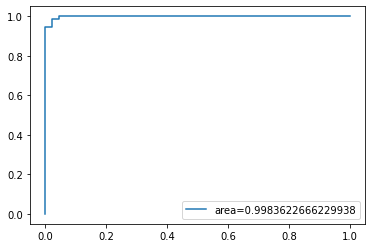

In [ ]:
#ROC/AUC Curve
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, log_loss
log_loss(y_test,y_test_prob)

0.22825900504463598

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        41         2
true:yes        1        70


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Grid Search Prediction Distribution

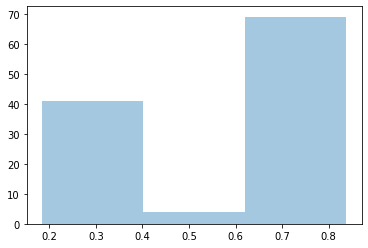

In [ ]:
# Plot the predicted probability distribution
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

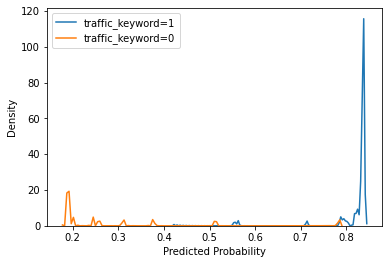

In [ ]:
# this is to plot the kde by label
sns.kdeplot(testPred[testPred['y_test']==1]['y_test_prob'],label='traffic_keyword=1');
sns.kdeplot(testPred[testPred['y_test']==0]['y_test_prob'],label='traffic_keyword=0');

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()

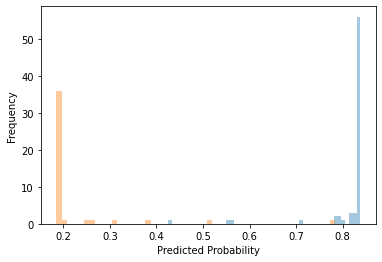

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='traffic_keyword=1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='traffic_keyword=0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Random Search Cross Validation

In [ ]:
layers = [(30), (30, 15), (30, 15, 7), (30, 15, 7, 3)]# Need to use tuple instead of list because of a bug related to nested list with Keras. https://datascience.stackexchange.com/questions/66341/cannot-clone-object-keras-wrappers-scikit-learn-kerasregressor-object-at-0x7fdc
activations = ['tanh', 'relu']
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = ['Adam', 'Adamax', 'Nadam']
# Glorot normal initializer, also called Xavier normal initializer.
# It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.
batch_size = [16, 32, 64, 128, 256, 512, 1024]
epochs=[50, 100, 150]
dropout=[0.0, 0.1, 0.2, 0.3, 0.4]
param_grid = dict(layers=layers, activation=activations, kernel_initializer=kernel_initializer, optimizer=optimizer, batch_size = batch_size, epochs=epochs, dropout=dropout)
param_grid

{'activation': ['tanh', 'relu'],
 'batch_size': [16, 32, 64, 128, 256, 512, 1024],
 'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
 'epochs': [50, 100, 150],
 'kernel_initializer': ['uniform',
  'lecun_uniform',
  'normal',
  'zero',
  'glorot_normal',
  'glorot_uniform',
  'he_normal',
  'he_uniform'],
 'layers': [30, (30, 15), (30, 15, 7), (30, 15, 7, 3)],
 'optimizer': ['Adam', 'Adamax', 'Nadam']}

In [ ]:
scoring = ['recall']

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)

In [ ]:
l = enumerate(layers)
print(list(l))

[(0, 30), (1, (30, 15)), (2, (30, 15, 7)), (3, (30, 15, 7, 3))]


In [ ]:
def create_model(layers, activation='relu', batch_size=32, epochs=50, dropout=0.2, kernel_initializer='normal', optimizer = 'adam'):
    # Add seed later
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,kernel_initializer=kernel_initializer, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(dropout))
        else:
            model.add(Dense(nodes,kernel_initializer=kernel_initializer))
            model.add(Activation(activation))
            model.add(Dropout(dropout))
            
    model.add(Dense(units = 1, activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

# Change function to estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

random_search = RandomizedSearchCV(model, param_grid, scoring=scoring, refit='recall', n_jobs=-1, cv=kfold, verbose=1)

random_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.0s finished


In [ ]:
random_result

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa7d13a8f28>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'batch_size': [16, 32, 64, 128, 256,
                                                       512, 1024],
                                        'dropout': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'epochs': [50, 100, 150],
                                        'kernel_initializer': ['uniform',
                                                               'lecun_uniform',
                                                               'normal', 'zero',
                                                               'glorot_normal',
                                             

In [ ]:
random_result.cv_results_

{'mean_fit_time': array([3.78247627, 6.00837509, 1.61261201, 1.11561497, 1.71611245,
        1.75621144, 1.33307648, 2.33495267, 2.12752716, 1.63257154]),
 'mean_score_time': array([0.08262761, 0.09238728, 0.05707057, 0.06044046, 0.04833428,
        0.08923046, 0.05669896, 0.10359367, 0.0965116 , 0.05684217]),
 'mean_test_recall': array([1.        , 1.        , 0.98249269, 0.9755117 , 0.98600146,
        0.9755117 , 0.98600146, 0.98249269, 0.97905702, 0.97902047]),
 'param_activation': masked_array(data=['tanh', 'relu', 'tanh', 'relu', 'relu', 'tanh', 'relu',
                    'relu', 'relu', 'relu'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_array(data=[32, 16, 1024, 1024, 64, 1024, 64, 128, 128, 128],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
 

In [ ]:
random_result.best_score_

1.0

In [ ]:
random_result.best_params_

{'activation': 'tanh',
 'batch_size': 32,
 'dropout': 0.4,
 'epochs': 100,
 'kernel_initializer': 'zero',
 'layers': (30, 15, 7),
 'optimizer': 'Nadam'}

## Random Search Final Model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

start = time.time()
nn = Sequential()
nn.add(Dense(30,input_dim=30,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(15,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(7,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(1,kernel_initializer= 'zero', activation='sigmoid'))

nn.compile(loss='binary_crossentropy',optimizer='Nadam')   
nn.fit(X_train,y_train, epochs=100,batch_size=32)
end = time.time()
fit_time = (end - start)

Epoch 1/100
455/455 [==============================] - 0s 490us/step - loss: 0.6793
Epoch 2/100
455/455 [==============================] - 0s 51us/step - loss: 0.6082
Epoch 3/100
455/455 [==============================] - 0s 51us/step - loss: 0.5193
Epoch 4/100
455/455 [==============================] - 0s 49us/step - loss: 0.4367
Epoch 5/100
455/455 [==============================] - 0s 53us/step - loss: 0.3588
Epoch 6/100
455/455 [==============================] - 0s 53us/step - loss: 0.3076
Epoch 7/100
455/455 [==============================] - 0s 55us/step - loss: 0.2864
Epoch 8/100
455/455 [==============================] - 0s 50us/step - loss: 0.2459
Epoch 9/100
455/455 [==============================] - 0s 51us/step - loss: 0.2270
Epoch 10/100
455/455 [==============================] - 0s 66us/step - loss: 0.2149
Epoch 11/100
455/455 [==============================] - 0s 58us/step - loss: 0.1908
Epoch 12/100
455/455 [==============================] - 0s 59us/step - loss: 0.1791


In [ ]:
fit_time

3.6858060359954834

## Random Search Prediction

In [ ]:
start_time = time.time()
y_test_predict = nn.predict_classes(X_test)
end_time = time.time()
predict_time = end_time - start_time

In [ ]:
predict_time

0.05567789077758789

In [ ]:
y_test_prob = nn.predict_proba(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.994947,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.006245,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.006245,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.994985,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.994985,1


## Random Search Model Performance

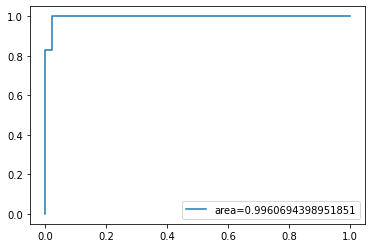

In [ ]:
#ROC/AUC Curve
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, log_loss
log_loss(y_test,y_test_prob)

0.053125584048725534

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        42         1
true:yes        0        71


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



## Random Search Prediction Distribution

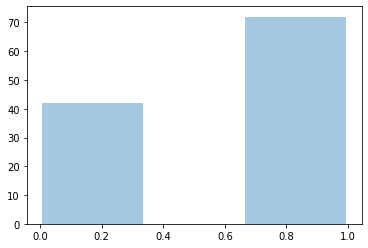

In [ ]:
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

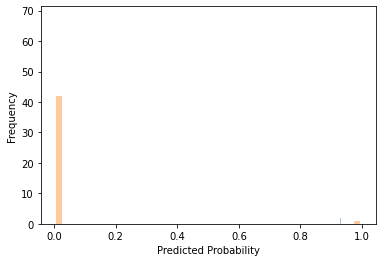

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Bayesian Optimization Grid Search

In [ ]:
N_FOLDS = StratifiedKFold(n_splits=3, shuffle=True)
MAX_EVALS = 2

In [ ]:
layers = [(30), (30, 15), (30, 15, 7), (30, 15, 7, 3)]# Need to use tuple instead of list because of a bug related to nested list with Keras. https://datascience.stackexchange.com/questions/66341/cannot-clone-object-keras-wrappers-scikit-learn-kerasregressor-object-at-0x7fdc
activation = ['tanh', 'relu']
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = ['Adam', 'Adamax', 'Nadam']
batch_size = [16, 32, 64, 128, 256, 512, 1024]
epochs=[50, 100, 150]
param_grid = dict(layers=layers, activation=activation, kernel_initializer=kernel_initializer, optimizer=optimizer, batch_size = batch_size, epochs=epochs)
param_grid

{'activation': ['tanh', 'relu'],
 'batch_size': [16, 32, 64, 128, 256, 512, 1024],
 'epochs': [50, 100, 150],
 'kernel_initializer': ['uniform',
  'lecun_uniform',
  'normal',
  'zero',
  'glorot_normal',
  'glorot_uniform',
  'he_normal',
  'he_uniform'],
 'layers': [30, (30, 15), (30, 15, 7), (30, 15, 7, 3)],
 'optimizer': ['Adam', 'Adamax', 'Nadam']}

In [ ]:
l = enumerate(layers)
print(list(l))

[(0, 30), (1, (30, 15)), (2, (30, 15, 7)), (3, (30, 15, 7, 3))]


In [ ]:
def create_model(layers, activation='relu', batch_size=32, epochs=50, kernel_initializer='normal', optimizer = 'adam'):
    # Add seed later
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,kernel_initializer=kernel_initializer, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
#             model.add(Dropout(dropout))
        else:
            model.add(Dense(nodes,kernel_initializer=kernel_initializer))
            model.add(Activation(activation))
#             model.add(Dropout(dropout))
            
    model.add(Dense(units = 1, activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [ ]:
# Change function to estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
# Space
space = {
    'layers': hp.choice('layers', layers),
    'activation': hp.choice('activation', activation),
    'kernel_initializer': hp.choice('kernel_initializer', kernel_initializer),
    'optimizer': hp.choice('optimizer', optimizer),    
    'batch_size': hp.choice('batch_size', batch_size),    
    'epochs': hp.choice('epochs', epochs),        
#     'dropout': hp.choice('dropout', dropout)      
#     'tol' : hp.uniform('tol', 0.00001, 1), #Tolerance for stopping criteria
#     'C' : hp.uniform('C', 0.0001, 10000),
#     'penalty': hp.choice('penalty',['l1', 'l2', 'none']),
# #     'l1_ratio': hp.uniform('l1_ratio', 0, 1),
#     'max_iter' : hp.choice('max_iter', range(5,1000)) #Maximum number of iterations taken for the solvers to converge
}

In [ ]:
# Objective function
def objective(params, n_folds = N_FOLDS):

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC
    
    model = KerasClassifier(build_fn=create_model, verbose=0,**params)
    scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='precision', n_jobs=-1)

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe_algorithm, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 2/2 [00:04<00:00,  2.47s/it, best loss: 0.030612244897959218]


In [ ]:
best

{'activation': 0,
 'batch_size': 6,
 'epochs': 0,
 'kernel_initializer': 4,
 'layers': 2,
 'optimizer': 1}

In [ ]:
param_grid

{'activation': ['tanh', 'relu'],
 'batch_size': [16, 32, 64, 128, 256, 512, 1024],
 'epochs': [50, 100, 150],
 'kernel_initializer': ['uniform',
  'lecun_uniform',
  'normal',
  'zero',
  'glorot_normal',
  'glorot_uniform',
  'he_normal',
  'he_uniform'],
 'layers': [30, (30, 15), (30, 15, 7), (30, 15, 7, 3)],
 'optimizer': ['Adam', 'Adamax', 'Nadam']}

## Bayesian Optimization Final Model

In [ ]:
# Set seeds
import random
import tensorflow as tf
import keras.backend as K
random.seed(0)
np.random.seed(0)
# tf.compat.v1.set_random_seed(0)
# tf.random.set_random_seed(0)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

start = time.time()
nn = Sequential()
nn.add(Dense(30,input_dim=30,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(15,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(7,activation='tanh'))
nn.add(Dropout(0.4))
nn.add(Dense(1,kernel_initializer= 'glorot_normal', activation='sigmoid'))
#init_weights = np.array(nn.get_weights()[0]).sum()
nn.compile(loss='binary_crossentropy',optimizer='Adamax')   
# nn.compile(optimizer=keras.optimizers.RMSprop(lr=1e-2),loss=keras.losses.MSE)
nn.fit(X_train,y_train, epochs=50,batch_size=1024)
end = time.time()
fit_time = (end - start)
print('fit time is: ', fit_time)
start_time = time.time()
y_test_predict = nn.predict_classes(X_test)
end_time = time.time()
predict_time = end_time - start_time
print('predict time is: ', predict_time)
y_test_predict.sum()

Epoch 1/50
455/455 [==============================] - 0s 387us/step - loss: 0.9983
Epoch 2/50
455/455 [==============================] - 0s 15us/step - loss: 0.9032
Epoch 3/50
455/455 [==============================] - 0s 15us/step - loss: 0.8362
Epoch 4/50
455/455 [==============================] - 0s 12us/step - loss: 0.8121
Epoch 5/50
455/455 [==============================] - 0s 13us/step - loss: 0.7154
Epoch 6/50
455/455 [==============================] - 0s 11us/step - loss: 0.6805
Epoch 7/50
455/455 [==============================] - 0s 13us/step - loss: 0.6474
Epoch 8/50
455/455 [==============================] - 0s 13us/step - loss: 0.6054
Epoch 9/50
455/455 [==============================] - 0s 12us/step - loss: 0.5525
Epoch 10/50
455/455 [==============================] - 0s 9us/step - loss: 0.5699
Epoch 11/50
455/455 [==============================] - 0s 8us/step - loss: 0.5254
Epoch 12/50
455/455 [==============================] - 0s 9us/step - loss: 0.5611
Epoch 13/50
455

72

## Neural Network Model Prediction

In [ ]:
y_test_prob = nn.predict_proba(X_test)

In [ ]:
testPred = X_test.copy()
testPred['y_test'], testPred['y_test_prob'], testPred['y_test_predict']=[y_test,y_test_prob,y_test_predict]
testPred.head()

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness,mean concave points,mean concavity,mean fractal dimension,mean perimeter,mean radius,mean smoothness,mean symmetry,mean texture,perimeter error,radius error,smoothness error,symmetry error,texture error,worst area,worst compactness,worst concave points,worst concavity,worst fractal dimension,worst perimeter,worst radius,worst smoothness,worst symmetry,worst texture,y_test,y_test_prob,y_test_predict
204,-0.221053,-0.355912,-0.231333,-0.161929,-0.079018,-0.491999,0.027651,-0.276232,-0.109847,0.132176,-0.448110,-0.470694,0.234114,0.413949,-0.160486,-0.182696,-0.032743,-0.029327,-0.329612,-0.313616,-0.356299,-0.104741,-0.199563,-0.024412,0.196958,-0.333935,-0.269040,0.448503,0.183204,-0.168905,1,0.923457,1
70,1.225780,-0.500666,0.308825,-0.305168,-0.793157,1.351264,-0.027309,0.789060,0.241064,-1.160679,1.302886,1.366877,-0.446227,-0.838325,0.470149,1.296951,1.384594,-0.865695,-0.809083,-0.760851,1.732277,-0.131459,0.978975,-0.016736,-1.000578,1.746605,1.779007,-0.572873,-0.565828,0.147012,0,0.056968,0
131,0.175418,-0.594561,-0.140496,-0.124794,-0.504551,0.267377,0.340350,0.824140,0.725686,-0.685782,0.400820,0.378508,0.913744,0.435855,0.044296,0.112838,0.249497,-0.267004,-0.795764,-0.781898,0.484159,-0.094562,0.560244,0.512911,-0.208132,0.525386,0.619345,0.974533,-0.103143,0.052562,0,0.070303,0
431,-0.547998,0.417599,-0.020461,0.554262,0.835972,-0.532101,0.516599,-0.539846,-0.142993,1.165609,-0.432457,-0.490575,0.643316,-0.002259,-0.374576,-0.327740,-0.824604,0.986380,0.160756,0.441152,-0.641257,0.054930,-0.622863,-0.152986,0.534440,-0.525756,-0.701842,0.553709,-0.557739,-0.450625,1,0.946121,1
540,-0.428529,0.874216,0.509965,0.783709,0.649494,-0.716683,0.145150,-0.592724,-0.269044,0.711976,-0.713374,-0.734828,0.247636,0.023298,-1.128546,-0.612877,-0.457547,1.703076,-0.259386,0.999969,-0.743216,-0.270137,-0.691687,-0.443716,-0.144403,-0.848337,-0.830233,0.093432,-0.924975,-0.976611,1,0.946505,1


## Neural Network Model Performance

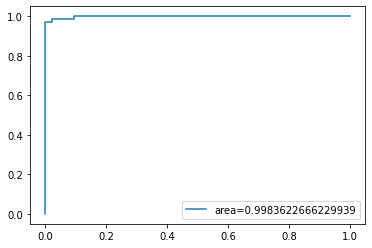

In [ ]:
#ROC/AUC Curve
from sklearn import metrics
# y_test_prob=et_gs.predict_proba(X_test)[:,1]
fpr,tpr, _=metrics.roc_curve(y_test,y_test_prob)
auc=metrics.roc_auc_score(y_test,y_test_prob)
plt.plot(fpr,tpr,label="area="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
log_loss(y_test,y_test_prob)

0.10926605663017223

In [ ]:
cm = confusion_matrix(y_test, y_test_predict)
cmtx = pd.DataFrame(cm, index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes'])
print(cmtx)

          pred:no  pred:yes
true:no        41         2
true:yes        1        70


In [ ]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Neural Network Model Prediction Distribution

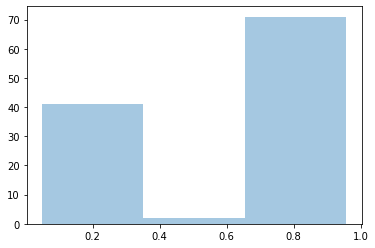

In [ ]:
# Plot the predicted probability distribution
sns.distplot(y_test_prob, label='Predicted Probability', kde=False)

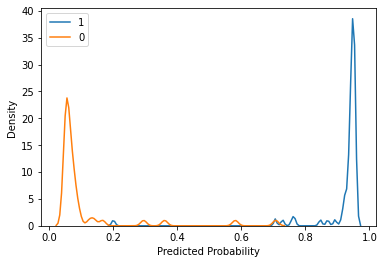

In [ ]:
# this is to plot the kde by label
sns.kdeplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1');
sns.kdeplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0');

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()

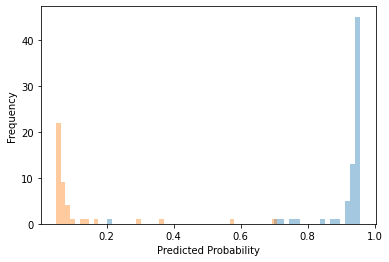

In [ ]:
# this is to plot the kde by label
sns.distplot(testPred[testPred['y_test']==1]['y_test_prob'],label='1', kde=False);
sns.distplot(testPred[testPred['y_test']==0]['y_test_prob'],label='0', kde=False);

# add labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()